In [37]:
# === Setup: Pfade & Imports ===============================================
from pathlib import Path
import json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Datei einlesen
CSV_PATH = Path("/Users/Startklar/Documents/GitHub/KR-KE/data/fmea_multi_domain.csv")

# Ordner für Outputs
OUT_DIR = Path("output")

df_raw = pd.read_csv(CSV_PATH)

In [45]:
# In zeile 17 fehlt ein Wert, deswegen Zeile verrutscht, droppe diese Zeile erstmal
# df_raw.head(50)
df_raw = df_raw.drop(index=17).reset_index(drop=True)

In [46]:
df_raw.insert(0, "risk_id", [f"R{i+1}" for i in range(len(df_raw))])
df_raw.head(5)

,risk_id,Domäne,Abteilung,Prozess,Fehler,Ursache,Wirkung,Bedeutung (B),Auftreten (A),Entdeckung (E),Bestehende Kontrolle,Verantwortlich,Datensensitivität,Prozesskritikalität,SLA-Auswirkung,RPN
0,R1,Order-to-Cash,Vertrieb,Angebotserstellung,Falscher Listenpreis im Angebot,Preisregel im BI-Tool veraltet,Margenverlust und Reklamation,7,5,6,Monatliche Preislistenprüfung,Sales Operations,mittel,hoch,mittel,210
1,R2,Order-to-Cash,Vertrieb,Auftragserfassung,Falsche Kundennummer,Manuelle Eingabe ohne Validierung,Fehlrouting und Verzögerung,6,6,5,Validierung gegen CRM,Innendienst,niedrig,mittel,hoch,180
2,R3,Procure-to-Pay,Einkauf,Lieferantenauswahl,Lieferant nicht qualifiziert,Qualifikationsnachweis fehlt,Qualitätsmängel,8,4,6,Approved-Vendor-List,Strategischer Einkauf,niedrig,hoch,mittel,192
3,R4,Procure-to-Pay,Einkauf,Bestellabwicklung,Verspätete Lieferung,Fehlende Lieferanten-ETA,Produktionsstillstand,9,5,4,SLA im Rahmenvertrag,Operativer Einkauf,niedrig,hoch,hoch,180
4,R5,Plan-to-Produce,Produktion,Maschinenlauf,Ungeplanter Maschinenausfall,Wartungsintervall überschritten,Stillstand und Ausschuss,9,4,4,TPM und Sensorüberwachung,Instandhaltung,niedrig,hoch,hoch,144


In [47]:
df_raw.dtypes

risk_id                 object
Domäne                  object
Abteilung               object
Prozess                 object
Fehler                  object
Ursache                 object
Wirkung                 object
Bedeutung (B)            int64
Auftreten (A)            int64
Entdeckung (E)          object
Bestehende Kontrolle    object
Verantwortlich          object
Datensensitivität       object
Prozesskritikalität     object
SLA-Auswirkung          object
RPN                     object
dtype: object

DTypes anpassen

In [48]:
df_raw["Entdeckung (E)"] = pd.to_numeric(df_raw["Entdeckung (E)"], errors="raise").astype(int)
df_raw["RPN"] = pd.to_numeric(df_raw["RPN"], errors="raise").astype(int)

Spalten-Mapping auf ein einheitliches Schema

In [49]:
# === Spalten-Mapping =======================================================
# Deine Spalten (deutsch) -> internes Schema (englisch), damit der Rest generisch funktioniert.

RENAME = {
    "Domäne": "domain",
    "Abteilung": "department",
    "Prozess": "process",
    "Fehler": "risk_title",
    "Ursache": "cause",
    "Wirkung": "effect",
    "Bedeutung (B)": "severity",     # S
    "Auftreten (A)": "occurrence",   # O
    "Entdeckung (E)": "detection",   # D
    "Bestehende Kontrolle": "control",
    "Verantwortlich": "owner",
    "Datensensitivität": "data_sensitivity",
    "Prozesskritikalität": "process_criticality",
    "SLA-Auswirkung": "sla_impact",
    "RPN": "RPN_given"               # vorhandene RPN aus der Datei 
}

df = df_raw.rename(columns=RENAME).copy()

df.head()

,risk_id,domain,department,process,risk_title,cause,effect,severity,occurrence,detection,control,owner,data_sensitivity,process_criticality,sla_impact,RPN_given
0,R1,Order-to-Cash,Vertrieb,Angebotserstellung,Falscher Listenpreis im Angebot,Preisregel im BI-Tool veraltet,Margenverlust und Reklamation,7,5,6,Monatliche Preislistenprüfung,Sales Operations,mittel,hoch,mittel,210
1,R2,Order-to-Cash,Vertrieb,Auftragserfassung,Falsche Kundennummer,Manuelle Eingabe ohne Validierung,Fehlrouting und Verzögerung,6,6,5,Validierung gegen CRM,Innendienst,niedrig,mittel,hoch,180
2,R3,Procure-to-Pay,Einkauf,Lieferantenauswahl,Lieferant nicht qualifiziert,Qualifikationsnachweis fehlt,Qualitätsmängel,8,4,6,Approved-Vendor-List,Strategischer Einkauf,niedrig,hoch,mittel,192
3,R4,Procure-to-Pay,Einkauf,Bestellabwicklung,Verspätete Lieferung,Fehlende Lieferanten-ETA,Produktionsstillstand,9,5,4,SLA im Rahmenvertrag,Operativer Einkauf,niedrig,hoch,hoch,180
4,R5,Plan-to-Produce,Produktion,Maschinenlauf,Ungeplanter Maschinenausfall,Wartungsintervall überschritten,Stillstand und Ausschuss,9,4,4,TPM und Sensorüberwachung,Instandhaltung,niedrig,hoch,hoch,144


Bereinigung & RPN (neu) berechnen; Abgleich mit gegebener RPN

In [ ]:
# === Bereinigung & RPN-Berechnung (robust) =================================
from IPython.display import display

# def coerce_1_10(x):
#    """S/O/D sicher in [1..10] bringen; NaNs -> 5 als neutraler Ersatz."""
#    try:
#        v = float(str(x).replace(",", ".").strip())
#    except Exception:
#        v = 5.0
#    v = 1.0 if v < 1 else (10.0 if v > 10 else v)
#    return int(round(v))

# S/O/D bereinigen
#for col in ["severity", "occurrence", "detection"]:
#    df[col] = df[col].apply(coerce_1_10).astype(int)

# RPN neu berechnen
df["RPN_calc"] = df["severity"] * df["occurrence"] * df["detection"]




,risk_id,risk_title,severity,occurrence,detection,RPN_given,RPN_given_num,RPN_calc,RPN_diff
0,R1,Falscher Listenpreis im Angebot,7,5,6,210,210,210,0
1,R2,Falsche Kundennummer,6,6,5,180,180,180,0
2,R3,Lieferant nicht qualifiziert,8,4,6,192,192,192,0
3,R4,Verspätete Lieferung,9,5,4,180,180,180,0
4,R5,Ungeplanter Maschinenausfall,9,4,4,144,144,144,0
5,R6,Fehlklassifikation Gut/Schlecht,8,4,5,160,160,160,0
6,R7,Falsche Artikel gepickt,7,6,5,210,210,210,0
7,R8,Falscher Spediteur gebucht,6,5,5,150,150,150,0
8,R9,Doppelte Rechnung bezahlt,8,3,6,144,144,144,0
9,R10,Falsche Periodenabgrenzung,7,4,5,140,140,140,0


Empfehlungsregeln (Decision Support, leichtgewichtig)

In [54]:
# === Wissensbasierte Regeln (Heuristiken) =================================
# Passe die Regeln auf eure Domäne an. Hier ein sinnvoller Startmix für Business/IT/Compliance:

def recommend(row):
    recs, flags = [], []
    s, o, d = row.severity, row.occurrence, row.detection
    effect = str(row.effect).lower()
    cause  = str(row.cause).lower()
    title  = str(row.risk_title).lower()
    dom    = str(row.get("domain","")).lower()
    dept   = str(row.get("department","")).lower()

    # A) Sofortmaßnahme bei hoher Schwere & Häufigkeit
    if s >= 8 and o >= 5:
        recs.append("Sofortmaßnahme: Design/Prozess anpassen")

    # B) Erkennung stärken bei schlechter Detektierbarkeit
    if d <= 4:
        recs.append("Erkennung stärken: Inspektion/Monitoring verdichten")

    # C) Management-Flag bei Produktions-/Stillstand-/SLA-Effekten
    if any(k in effect for k in ["stillstand","produktion","sla","vertragsstrafe","geschäftsunterbrechung"]):
        flags.append("Management-Flag")

    # D) Lieferkette absichern
    if any(k in cause for k in ["zuliefer","lieferant","vendor","liefer"]):
        recs.append("Zweitlieferant qualifizieren / SLA nachschärfen / Sicherheitsbestand")

    # E) Usability/Bedienung
    if any(k in (title+" "+cause) for k in ["ui","bedien","usability","kategorisierung"]):
        recs.append("Schulung + UI-/Prozess-Review")

    # F) Daten/Compliance (DSGVO/KYC/PII)
    if any(k in (title+" "+cause+" "+effect) for k in ["dsgvo","pii","kyc","aml","bußgeld","reputationsschaden"]):
        recs.append("Compliance-Maßnahmen prüfen/automatisieren")
        flags.append("Compliance-Risiko")

    # G) IT-Change/Incident
    if any(k in (title+" "+cause+" "+effect) for k in ["downtime","change","störung","incident","runbook","backup"]):
        recs.append("Change-/Incident-Runbooks nachschärfen; Testabdeckung erhöhen")

    return "; ".join(recs) if recs else "—", "; ".join(flags) if flags else "—"

df[["recommendation","flags"]] = df.apply(recommend, axis=1, result_type="expand")
df[["risk_id","risk_title","severity","occurrence","detection","RPN_calc","recommendation","flags"]].head(10)


,risk_id,risk_title,severity,occurrence,detection,RPN_calc,recommendation,flags
0,R1,Falscher Listenpreis im Angebot,7,5,6,210,—,—
1,R2,Falsche Kundennummer,6,6,5,180,—,—
2,R3,Lieferant nicht qualifiziert,8,4,6,192,—,—
3,R4,Verspätete Lieferung,9,5,4,180,Sofortmaßnahme: Design/Prozess anpassen; Erken...,Management-Flag
4,R5,Ungeplanter Maschinenausfall,9,4,4,144,Erkennung stärken: Inspektion/Monitoring verdi...,Management-Flag
5,R6,Fehlklassifikation Gut/Schlecht,8,4,5,160,—,—
6,R7,Falsche Artikel gepickt,7,6,5,210,—,—
7,R8,Falscher Spediteur gebucht,6,5,5,150,—,—
8,R9,Doppelte Rechnung bezahlt,8,3,6,144,—,—
9,R10,Falsche Periodenabgrenzung,7,4,5,140,—,—


In [60]:
df

,risk_id,domain,department,process,risk_title,cause,effect,severity,occurrence,detection,...,process_criticality,sla_impact,RPN_given,RPN_calc,RPN_diff,RPN_given_num,recommendation,flags,fuzzy_0_1,fuzzy_0_100
0,R1,Order-to-Cash,Vertrieb,Angebotserstellung,Falscher Listenpreis im Angebot,Preisregel im BI-Tool veraltet,Margenverlust und Reklamation,7,5,6,...,hoch,mittel,210,210,0,210,—,—,0.0,0.0
1,R2,Order-to-Cash,Vertrieb,Auftragserfassung,Falsche Kundennummer,Manuelle Eingabe ohne Validierung,Fehlrouting und Verzögerung,6,6,5,...,mittel,hoch,180,180,0,180,—,—,0.5,50.0
2,R3,Procure-to-Pay,Einkauf,Lieferantenauswahl,Lieferant nicht qualifiziert,Qualifikationsnachweis fehlt,Qualitätsmängel,8,4,6,...,hoch,mittel,192,192,0,192,—,—,0.0,0.0
3,R4,Procure-to-Pay,Einkauf,Bestellabwicklung,Verspätete Lieferung,Fehlende Lieferanten-ETA,Produktionsstillstand,9,5,4,...,hoch,hoch,180,180,0,180,Sofortmaßnahme: Design/Prozess anpassen; Erken...,Management-Flag,0.0,0.0
4,R5,Plan-to-Produce,Produktion,Maschinenlauf,Ungeplanter Maschinenausfall,Wartungsintervall überschritten,Stillstand und Ausschuss,9,4,4,...,hoch,hoch,144,144,0,144,Erkennung stärken: Inspektion/Monitoring verdi...,Management-Flag,0.0,0.0
5,R6,Plan-to-Produce,Qualität,Wareneingang,Fehlklassifikation Gut/Schlecht,Grenzwerte falsch parametriert,Ausschussquote steigt,8,4,5,...,mittel,mittel,160,160,0,160,—,—,0.0,0.0
6,R7,Warehouse & Logistics,Logistik,Kommissionierung,Falsche Artikel gepickt,Ähnliche Artikelnummern,Fehllieferung,7,6,5,...,mittel,hoch,210,210,0,210,—,—,0.0,0.0
7,R8,Warehouse & Logistics,Logistik,Transportplanung,Falscher Spediteur gebucht,Fehlendes Routing-Profil,Kostensteigerung und Verzögerung,6,5,5,...,mittel,mittel,150,150,0,150,—,—,0.5,50.0
8,R9,Record-to-Report,Finanzen,Rechnungsprüfung,Doppelte Rechnung bezahlt,Duplikat nicht erkannt,Liquiditätsverlust,8,3,6,...,mittel,mittel,144,144,0,144,—,—,0.0,0.0
9,R10,Record-to-Report,Finanzen,Abschluss,Falsche Periodenabgrenzung,Fehlende Rückstellung,Fehlende Aussagekraft der KPIs,7,4,5,...,mittel,niedrig,140,140,0,140,—,—,0.0,0.0


Fuzzy-Logik (unscharfe Intensität, kurz & kommentiert)

In [55]:
# === Fuzzy-Logik: low/med/high auf 1..10 (Dreiecke) =======================
# Warum? Statt harter Grenzen ("ab 7 hoch") erlauben wir Teil-Zugehörigkeiten (0..1).
# Drei Dreiecke:
#   low  = (0, 0, 4)
#   med  = (3, 5, 7)
#   high = (6, 10, 10)

def tri(x, a, b, c):
    if x <= a or x >= c: return 0.0
    if x == b: return 1.0
    if x < b:  return (x-a)/(b-a)
    return (c-x)/(c-b)

def fuzzy_intensity(s, o, d):
    S = {"low": tri(s,0,0,4), "med": tri(s,3,5,7), "high": tri(s,6,10,10)}
    O = {"low": tri(o,0,0,4), "med": tri(o,3,5,7), "high": tri(o,6,10,10)}
    D = {"low": tri(d,0,0,4), "med": tri(d,3,5,7), "high": tri(d,6,10,10)}

    # Mini-Regelbasis (min-AND, max-OR):
    # R1: S high & O high  -> Intensity high
    r1 = min(S["high"], O["high"])
    # R2: S high & D low   -> Intensity high
    r2 = min(S["high"], D["low"])
    # R3: S med  & O med   -> Intensity med
    r3 = min(S["med"], O["med"])
    # R4: S low  & O low   -> Intensity low
    r4 = min(S["low"], O["low"])

    mu_low  = r4
    mu_med  = r3
    mu_high = max(r1, r2)

    # Defuzzifizierung: gewichtete Repräsentanten (low=0.2, med=0.5, high=0.85)
    num = mu_low*0.2 + mu_med*0.5 + mu_high*0.85
    den = max(mu_low + mu_med + mu_high, 1e-9)
    return float(num/den)

df["fuzzy_0_1"]   = [fuzzy_intensity(float(s),float(o),float(d)) for s,o,d in zip(df.severity, df.occurrence, df.detection)]
df["fuzzy_0_100"] = (df["fuzzy_0_1"] * 100).round(1)
df[["risk_id","RPN_calc","fuzzy_0_100"]].head(10)


,risk_id,RPN_calc,fuzzy_0_100
0,R1,210,0.0
1,R2,180,50.0
2,R3,192,0.0
3,R4,180,0.0
4,R5,144,0.0
5,R6,160,0.0
6,R7,210,0.0
7,R8,150,50.0
8,R9,144,0.0
9,R10,140,0.0


Top-10 (primär Fuzzy, sekundär RPN) — Plot

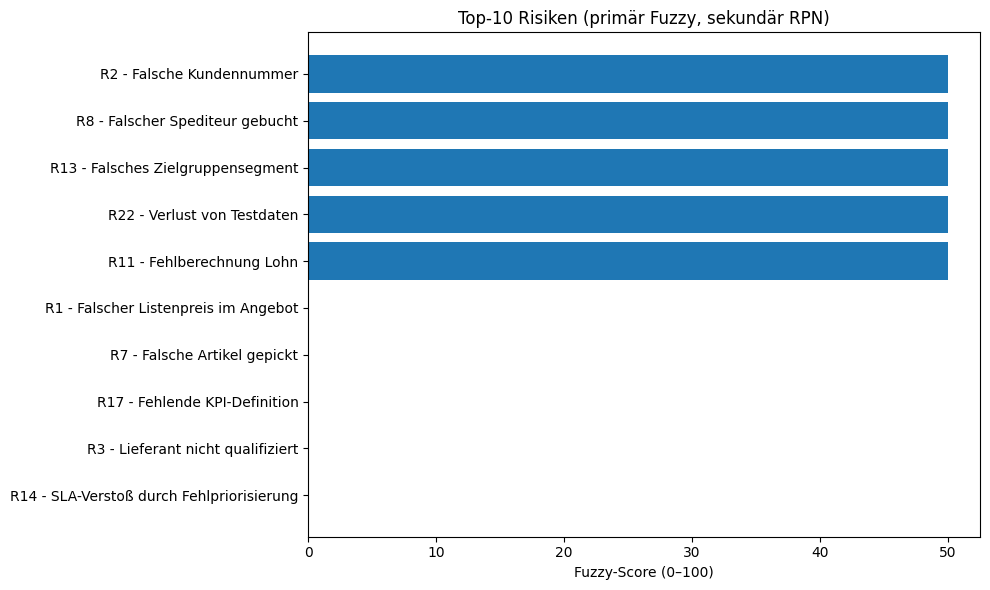

In [56]:
# === Plot 1: Top-10 Risiken ==============================================
RANKED = df.sort_values(["fuzzy_0_100","RPN_calc"], ascending=False).copy()
top = RANKED.head(10)

plt.figure(figsize=(10,6))
y = np.arange(len(top))
plt.barh(y, top["fuzzy_0_100"])   # keine Farben festlegen (Default)
plt.yticks(y, top["risk_id"].astype(str) + " - " + top["risk_title"].astype(str))
plt.gca().invert_yaxis()
plt.xlabel("Fuzzy-Score (0–100)")
plt.title("Top-10 Risiken (primär Fuzzy, sekundär RPN)")
plt.tight_layout()
plt.savefig(OUT_DIR/"top10_risks.png")
plt.show()


S–O-Heatmap (Hotspots)

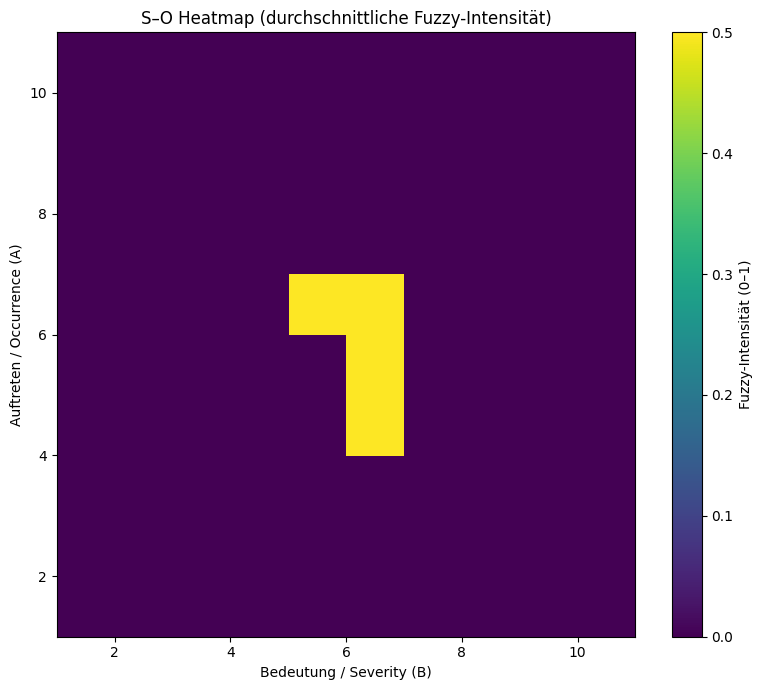

In [57]:
# === Plot 2: S–O Heatmap ==================================================
grid = np.full((10,10), np.nan)
counts = np.zeros((10,10))

for s,o,val in zip(df.severity, df.occurrence, df.fuzzy_0_1):
    si, oi = int(s)-1, int(o)-1
    if np.isnan(grid[oi, si]): grid[oi, si] = val
    else:                       grid[oi, si] += val
    counts[oi, si] += 1

with np.errstate(invalid='ignore'):
    grid = np.divide(grid, counts, out=np.zeros_like(grid), where=counts>0)

plt.figure(figsize=(8,7))
im = plt.imshow(grid, origin="lower", extent=[1,11,1,11], aspect="auto")
plt.colorbar(im, label="Fuzzy-Intensität (0–1)")
plt.xlabel("Bedeutung / Severity (B)")
plt.ylabel("Auftreten / Occurrence (A)")
plt.title("S–O Heatmap (durchschnittliche Fuzzy-Intensität)")
plt.tight_layout()
plt.savefig(OUT_DIR/"so_heatmap.png")
plt.show()


knowledge.json (maschinenlesbare Wissensrepräsentation)

In [58]:
# === Export: knowledge.json ===============================================
kb = {"risks": []}
for _, r in RANKED.iterrows():
    kb["risks"].append({
        "id": str(r.risk_id),
        "label": str(r.risk_title),
        "domain": str(r.get("domain","")),
        "department": str(r.get("department","")),
        "process": str(r.get("process","")),
        "cause": str(r.get("cause","")),
        "effect": str(r.get("effect","")),
        "control": str(r.get("control","")),
        "owner": str(r.get("owner","")),
        "S": int(r.severity),
        "O": int(r.occurrence),
        "D": int(r.detection),
        "RPN_calc": int(r.RPN_calc),
        "RPN_given": None if "RPN_given" not in r or pd.isna(r.RPN_given) else int(r.RPN_given),
        "recommendation": str(r.recommendation),
        "flags": str(r.flags),
        "data_sensitivity": str(r.get("data_sensitivity","")),
        "process_criticality": str(r.get("process_criticality","")),
        "sla_impact": str(r.get("sla_impact","")),
        "fuzzy_score": float(r.fuzzy_0_1)
    })

# out_json = OUT_DIR / "knowledge.json"
# out_json.write_text(json.dumps(kb, ensure_ascii=False, indent=2), encoding="utf-8")
# print("Export ->", out_json.resolve())


(Optional) Vergleich RPN_given vs. RPN_calc (Qualitätssicherung)

In [59]:
# === Optional: RPN-Abgleichsreport ========================================
if "RPN_given" in df.columns:
    cmp = df[["risk_id","risk_title","RPN_given","RPN_calc","severity","occurrence","detection"]].copy()
    cmp["diff"] = cmp["RPN_given"] - cmp["RPN_calc"]
    display(cmp.sort_values("diff", ascending=False).head(10))
else:
    print("Keine RPN_given-Spalte vorhanden.")


,risk_id,risk_title,RPN_given,RPN_calc,severity,occurrence,detection,diff
0,R1,Falscher Listenpreis im Angebot,210,210,7,5,6,0
12,R13,Falsches Zielgruppensegment,150,150,5,6,5,0
21,R22,Verlust von Testdaten,144,144,6,4,6,0
20,R21,Nicht gemeldeter Beinaheunfall,192,192,8,4,6,0
19,R20,Stromunterbrechung,90,90,9,2,5,0
18,R19,Falsche Vertragsversion,120,120,8,3,5,0
17,R18,Unvollständige KYC-Prüfung,108,108,9,2,6,0
16,R17,Fehlende KPI-Definition,210,210,7,5,6,0
15,R16,Verzögerte Störungseingrenzung,175,175,7,5,5,0
14,R15,Ungeplante Downtime nach Change,135,135,9,3,5,0
